# Comparing Euler Method and Brian2 Euler Integration

## Introduction
Euler's method is a simple numerical integration technique used to approximate the solution of differential equations. Brian2, a simulator for spiking neural networks, provides an implementation of the Euler method (among others) to integrate equations governing neural dynamics.

In this experiment, we simulate a simple neuron model where:

- The membrane potential $v$ follows a leaky integrator equation:
  $$
  \frac{dv}{dt} = \frac{-v + I}{\tau}
  $$
- The synaptic current $I$ decays exponentially:
  $$
  \frac{dI}{dt} = -\frac{I}{\tau_f}
  $$
- Presynaptic spikes inject discrete currents into the postsynaptic neuron at specific times.

To ensure that the manually implemented Euler method produces numerically identical results to Brian2, we set the synaptic time constant in Brian2 as:
  $$
  \tau_f = dt
  $$
This choice ensures that the synaptic current decay is consistent across both implementations.

## Purpose
We compare two different implementations of numerical integration:

1. **Brian2's built-in Euler method**: This uses `NeuronGroup` to simulate the neuron and `StateMonitor` to track its state over time.
2. **Custom Euler method**: A manually implemented forward-Euler update scheme is used to approximate the same differential equations.

## Unit Correction in Brian2 Synaptic Update

In Brian2, all computations are internally handled in SI units (seconds, volts), but simulation parameters are often specified in milliseconds and millivolts. When updating the synaptic current upon a presynaptic spike, the equation:

$$
I \gets I + \frac{I_0}{dt} \times ms
$$

leads to:

$$
\frac{\text{mV}}{\text{ms}} \times 10^{-3} \text{s} = \text{mV} \times 10^{-3}
$$

which is 1000 times too large. To correct this mismatch, we divide by 1000:

$$
I \gets I + \frac{I_0}{dt} \times \frac{ms}{1000}
$$

This ensures that the injected current magnitude is consistent with Brian2's unit system.

## Expected Outcome
Since both methods use the Euler integration scheme, they should produce identical or very similar outputs. Any differences would likely arise from numerical precision, time step selection, or implementation details. The comparison helps validate that our manual Euler implementation correctly follows the neuron dynamics as simulated in Brian2.

The results are plotted to visually inspect the alignment between Brian2’s Euler method and our custom implementation.



## Simple Leaky-and-Integrate Neuoron

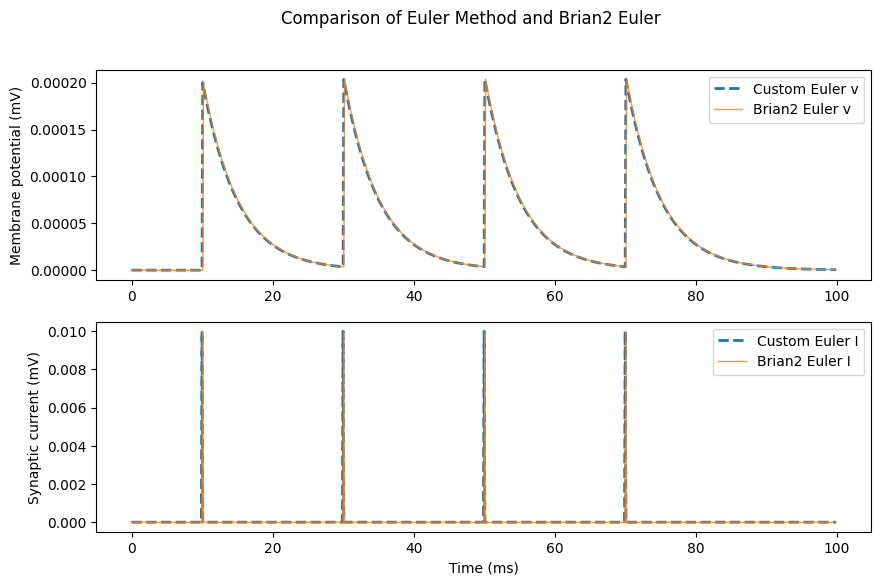

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Simulation parameters
duration    = 100 * ms  # Total simulation time
dt          = 0.1 * ms        # Time step
tau         = 5 * ms         # Membrane time constant
tauf        = dt            # Synaptic current decay time constant
I0          = 1 * mV          # Synaptic input magnitude per spike
spike_times = [10, 30, 50, 70] * ms  # Presynaptic spike times

defaultclock.dt = dt  # Set simulation time step

# Start a clean simulation scope
start_scope()

# Neuron model equations
eqs = '''
dv/dt = (-v + I) / tau : volt
dI/dt = -I / tauf : volt
'''

# Create a single postsynaptic neuron
G = NeuronGroup(1, eqs, method='euler')

# Presynaptic spike generator
spike_gen = SpikeGeneratorGroup(1, indices=[0] * len(spike_times), times=spike_times)

# Define synapse: inject current on presynaptic spikes
S = Synapses(spike_gen, G, on_pre='I += (I0/dt)*ms/1000')
S.connect()

# Initialize variables
G.v = 0 * mV
G.I = 0 * mV

# Monitor voltage and current
mon = StateMonitor(G, ['v', 'I'], record=True)

# Run the Brian2 simulation
run(duration)

# Time vector for custom Euler method
time = np.arange(0, duration/ms, dt/ms)
v_euler = np.zeros_like(time)  # Membrane potential
I_euler = np.zeros_like(time)  # Synaptic current

# Custom Euler method simulation
for t_idx, t in enumerate(time[:-1]):
    if t in spike_times/ms:
        I_euler[t_idx] += I0/dt * ms  # Add synaptic input

    # Update using Euler's method
    dv_dt = (-v_euler[t_idx] + I_euler[t_idx]) / tau * dt

    v_euler[t_idx + 1] = v_euler[t_idx] + dv_dt

# Plot comparison
plt.figure(figsize=(10, 6))

# Compare membrane potentials
plt.subplot(2, 1, 1)
plt.plot(time, v_euler, label="Custom Euler v", linestyle="dashed", alpha=1, linewidth=2)
plt.plot(mon.t/ms, mon.v[0]/mV, label="Brian2 Euler v", alpha=0.8, linewidth=1)
plt.ylabel("Membrane potential (mV)")
plt.legend()

# Compare synaptic currents
plt.subplot(2, 1, 2)
plt.plot(time, I_euler, label="Custom Euler I", linestyle="dashed", alpha=1, linewidth=2)
plt.plot(mon.t/ms, mon.I[0]/mV, label="Brian2 Euler I", alpha=0.8, linewidth=1)
plt.xlabel("Time (ms)")
plt.ylabel("Synaptic current (mV)")
plt.legend()

plt.suptitle("Comparison of Euler Method and Brian2 Euler")
plt.show()


## Adding a More Complex LIF Model

To further validate numerical equivalence, we extend the model to include a **Leaky Integrate-and-Fire (LIF) neuron** with thresholding and reset mechanisms:

- When $v$ crosses the threshold $v_{th}$, the neuron fires and resets:
  $$
  v \gets v_{reset} \quad \text{if} \quad v > v_{th}
  $$

To ensure numerical consistency, we apply the same thresholding and reset logic in our custom Euler method. The presynaptic spikes occur at defined times, injecting synaptic current in a way that matches Brian2's built-in update scheme. With these modifications, both implementations should remain numerically equivalent.

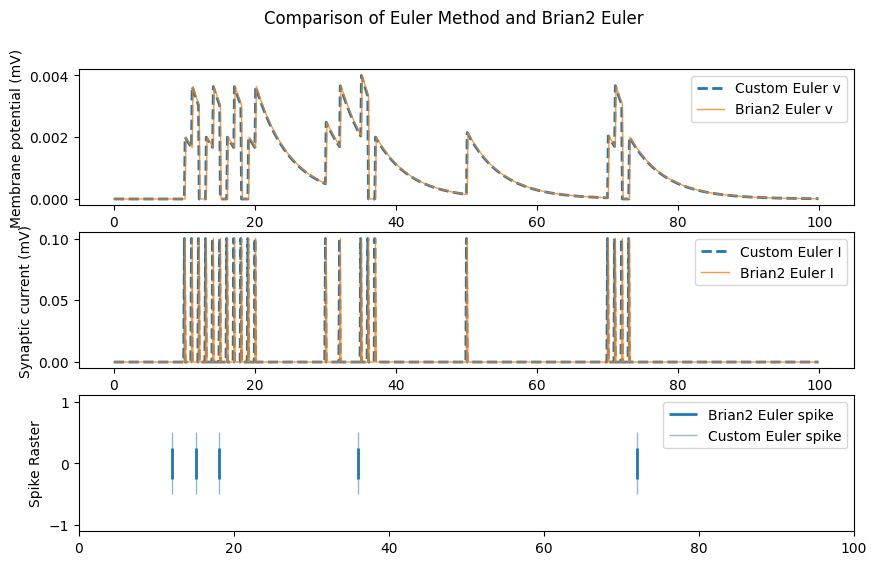

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Simulation parameters
duration    = 100 * ms  # Total simulation time
dt          = 0.1 * ms        # Time step
tau         = 5 * ms         # Membrane time constant
tauf        = dt            # Synaptic current decay time constant
I0          = 10 * mV          # Synaptic input magnitude per spike
spike_times = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 32, 35, 36, 37, 50, 70, 71, 72, 73] * ms  # Presynaptic spike times
v_th        = 0.004*mV
v_reset     = 0 * mV  # Reset voltage after spike

defaultclock.dt = dt  # Set simulation time step

# Start a clean simulation scope
start_scope()

# Neuron model equations
eqs = '''
dv/dt = (-v + I) / tau : volt
dI/dt = -I / tauf : volt
'''

# Create a single postsynaptic neuron
G = NeuronGroup(1, eqs, threshold='v > v_th', reset='v = v_reset', method='euler')

# Presynaptic spike generator
spike_gen = SpikeGeneratorGroup(1, indices=[0] * len(spike_times), times=spike_times)

# Define synapse: inject current on presynaptic spikes
S = Synapses(spike_gen, G, on_pre=f'I += (I0/{tauf/ms})/1000')
S.connect()

# Initialize variables
G.v = 0 * mV
G.I = 0 * mV

# Monitor voltage and current
mon = StateMonitor(G, ['v', 'I'], record=True)
spike_mon = SpikeMonitor(G)

# Run the Brian2 simulation
run(duration)

# Time vector for custom Euler method
time = np.arange(0, duration/ms, dt/ms)
v_euler = np.zeros_like(time)  # Membrane potential
I_euler = np.zeros_like(time)  # Synaptic current
spike_euler = np.zeros_like(time)  # Spike train (binary)
spiket_euler = []
# Custom Euler method simulation
for t_idx, t in enumerate(time[:-1]):
    if t in spike_times/ms:
        I_euler[t_idx] += I0/dt * ms  # Add synaptic input

    # Update using Euler's method
    dv_dt = (-v_euler[t_idx] + I_euler[t_idx]) / tau * dt
    dI_dt = -I_euler[t_idx] / tauf * dt

    v_euler[t_idx + 1] = v_euler[t_idx] + dv_dt
    I_euler[t_idx + 1] = I_euler[t_idx] + dI_dt

    # Apply threshold and reset in Euler method
    if v_euler[t_idx + 1] > v_th/mV:
        v_euler[t_idx + 1] = v_reset/mV  # Reset voltage
        spike_euler[t_idx + 1] = 1/dt*ms  # Mark spike event
        spiket_euler.append((t*ms)+dt)

# Plot comparison
plt.figure(figsize=(10, 6))

# Compare membrane potentials
plt.subplot(3, 1, 1)
plt.plot(time, v_euler, label="Custom Euler v", linestyle="dashed", alpha=1, linewidth=2)
plt.plot(mon.t/ms, mon.v[0]/mV, label="Brian2 Euler v", alpha=0.8, linewidth=1)
plt.ylabel("Membrane potential (mV)")
plt.legend()

# Compare synaptic currents
plt.subplot(3, 1, 2)
plt.plot(time, I_euler, label="Custom Euler I", linestyle="dashed", alpha=1, linewidth=2)
plt.plot(mon.t/ms, mon.I[0]/mV, label="Brian2 Euler I", alpha=0.8, linewidth=1)
plt.xlabel("Time (ms)")
plt.ylabel("Synaptic current (mV)")
plt.legend()

plt.subplot(3, 1, 3)
plt.eventplot(spike_mon.t/ms, lineoffsets=0, linelengths=0.5, label="Brian2 Euler spike", alpha=1, linewidth=2)
plt.eventplot(spiket_euler/ms, lineoffsets=0, linelengths=1, label="Custom Euler spike", alpha=0.5, linewidth=1)
plt.ylabel("Spike Raster")
plt.xlim(0, duration/ms)
plt.legend()

plt.suptitle("Comparison of Euler Method and Brian2 Euler")
plt.show()


## Adding Complexity to the Neuron Model

In this phase, we introduce more complexity to the neuron model by defining a new variable, $r$, for each neuron. This variable follows the dynamics:

$$
\frac{dr}{dt} = \frac{-r}{\tau_r} + o(t)
$$

where $o(t)$ represents the spike train, which is a binary signal (either 0 or 1). In essence, $r$ represents the neuron's firing behavior.

To implement this in **Brian2**, we define a **synapse** from the neuron to itself. When the neuron spikes, the variable $r$ increases by 1.

### Interpretation of $r$

The variable $r$ essentially represents a slow current received by the neuron. At each time step, $r$ is multiplied by a specific weight and contributes to increasing the membrane potential. To account for this, we define a new variable $I_s$ in the equation, which is updated based on synaptic weights and $r$.

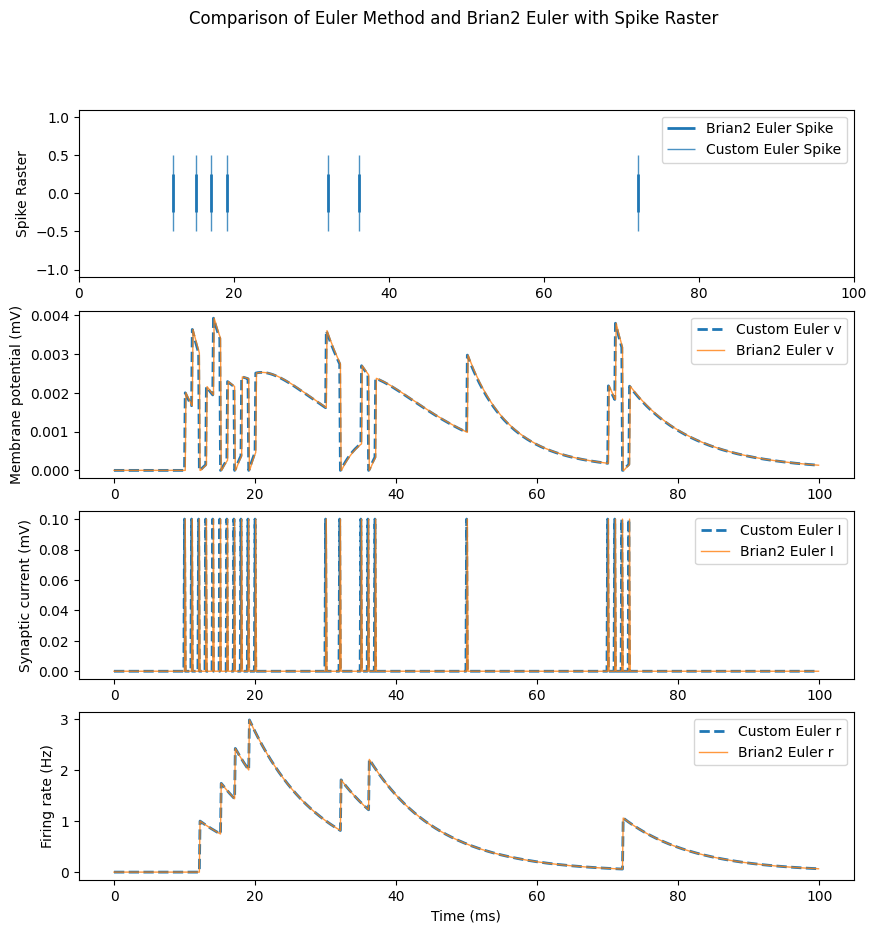

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Simulation parameters
duration    = 100 * ms  # Total simulation time
dt          = 0.1 * ms        # Time step
tau         = 5 * ms         # Membrane time constant
tauf        = dt            # Synaptic current decay time constant
taus        = 10 * ms       # Slow synaptic current decay time constant
wslow       = 0.001 * mV
I0          = 10 * mV         # Synaptic input magnitude per spike
spike_times = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 32, 35, 36, 37, 50, 70, 71, 72, 73] * ms  # Presynaptic spike times
v_th        = 0.004 * mV
v_reset     = 0 * mV  # Reset voltage after spike

defaultclock.dt = dt  # Set simulation time step

# Start a clean simulation scope
start_scope()

# Neuron model equations
eqs = '''
dv/dt = (-v + I_f + I_s) / tau : volt
dI_f/dt = -I_f / tauf : volt
dI_s/dt = (-I_s + wslow * r) / tauf : volt  # Continuous update of slow synapse
dr/dt = -r / taus  : 1
'''

# Create a single postsynaptic neuron
G = NeuronGroup(1, eqs, threshold='v > v_th', reset='v = v_reset', method='euler')


# Presynaptic spike generator
spike_gen = SpikeGeneratorGroup(1, indices=[0] * len(spike_times), times=spike_times)

# Define synapse: inject current on presynaptic spikes
S = Synapses(spike_gen, G, on_pre=f'I_f += (I0/{tauf/ms})/1000')
S.connect()

S2 = Synapses(G, G, on_pre ='r +=1')
S2.connect('i==j')


# Initialize variables
G.v = 0 * mV
G.I_f = 0 * mV
G.I_s = 0 * mV

# Monitor voltage, synaptic currents, and firing rate
mon = StateMonitor(G, ['v', 'I_f', 'r'], record=True)
spike_mon = SpikeMonitor(G)


# Run the Brian2 simulation
run(duration)

# Time vector for custom Euler method
time = np.arange(0, duration/ms, dt/ms)
v_euler = np.zeros_like(time)  # Membrane potential
I_euler = np.zeros_like(time)  # Synaptic current
spike_euler = np.zeros_like(time)  # Spike train 
r_euler = np.zeros_like(time)  # Slow synaptic current
spiket_euler = []

# Custom Euler method simulation
for t_idx, t in enumerate(time[:-1]):
    if t in spike_times/ms:
        I_euler[t_idx] += I0/dt * ms  # Add synaptic input

    # Update using Euler's method
    dv_dt = (-v_euler[t_idx] + I_euler[t_idx] + wslow/mV * r_euler[t_idx]) / tau * dt
    dI_dt = -I_euler[t_idx] / tauf * dt

    v_euler[t_idx + 1] = v_euler[t_idx] + dv_dt
    I_euler[t_idx + 1] = I_euler[t_idx] + dI_dt

    # Apply threshold and reset in Euler method
    if v_euler[t_idx + 1] > v_th/mV:
        v_euler[t_idx + 1] = v_reset/mV  # Reset voltage
        spike_euler[t_idx + 1] = 1/dt*ms  # Mark spike event
        spiket_euler.append((t * ms)+ dt)

    dr_dt = -r_euler[t_idx] / taus * dt + spike_euler[t_idx] * dt/ms
    r_euler[t_idx + 1] = r_euler[t_idx] + dr_dt

# Plot comparison
plt.figure(figsize=(10, 10))

# Spike raster plot
plt.subplot(4, 1, 1)
plt.eventplot(spike_mon.t/ms, lineoffsets=0, linelengths=0.5, label='Brian2 Euler Spike', alpha=1, linewidth=2)
plt.eventplot(spiket_euler/ms, lineoffsets=0, linelengths=1,  label="Custom Euler Spike", alpha=0.8, linewidth=1)
plt.ylabel("Spike Raster")
plt.xlim(0, duration/ms)
plt.legend()

# Compare membrane potentials
plt.subplot(4, 1, 2)
plt.plot(time, v_euler, label="Custom Euler v", linestyle="dashed", alpha=1, linewidth=2)
plt.plot(mon.t/ms, mon.v[0]/mV, label="Brian2 Euler v", alpha=0.8, linewidth=1)
plt.ylabel("Membrane potential (mV)")
plt.legend()

# Compare synaptic currents
plt.subplot(4, 1, 3)
plt.plot(time, I_euler, label="Custom Euler I", linestyle="dashed", alpha=1, linewidth=2)
plt.plot(mon.t/ms, mon.I_f[0]/mV, label="Brian2 Euler I", alpha=0.8, linewidth=1)
plt.ylabel("Synaptic current (mV)")
plt.legend()

# Compare firing rate
plt.subplot(4, 1, 4)
plt.plot(time, r_euler, label="Custom Euler r", linestyle="dashed", alpha=1, linewidth=2)
plt.plot(mon.t/ms, mon.r[0], label="Brian2 Euler r", alpha=0.8, linewidth=1)
plt.xlabel("Time (ms)")
plt.ylabel("Firing rate (Hz)")
plt.legend()

plt.suptitle("Comparison of Euler Method and Brian2 Euler with Spike Raster")
plt.show()


## Expanding the Neuron Model to a Population



In this step, instead of modeling a single neuron, we define a **population** of neurons, where each neuron has its own variable $r$. The recurrent slow synaptic weight is fixed and identical across all neurons.

Each neuron's variable $r$ contributes to its own membrane potential dynamics. This means that the slow synaptic activity affects the neuron's behavior over time, simulating a more biologically realistic interaction.

**Mathematical Model**

Each neuron in the population follows the same dynamics:

$$
\frac{dr_i}{dt} = \frac{-r_i}{\tau_r} + o_i(t)
$$

where:
- $r_i$ represents the neuron's internal firing rate,
- $\tau_r$ is the decay time constant for $r$,
- $o_i(t)$ is the spike train of the neuron (binary: 0 or 1),
- Each neuron has its own $r_i$, but the recurrent weight is shared.

The synaptic currents and membrane potential for each neuron evolve as:

$$
\frac{dI_{s,i}}{dt} = \frac{-I_{s,i} + w_{slow} \cdot r_i}{\tau_s}
$$

$$
\frac{dv_i}{dt} = \frac{-v_i + I_{f,i} + I_{s,i}}{\tau}
$$

where:
- $v_i$ is the membrane potential of the $i$-th neuron,
- $I_{f,i}$ is the fast synaptic input,
- $I_{s,i}$ is the slow recurrent input,
- $w_{slow}$ is the shared recurrent weight.

**Implementation in Brian2**

Each neuron in the population is simulated using the **Brian2 framework**, where:
- The population consists of multiple neurons.
- Each neuron receives input spikes at predefined times.
- A synapse from the neuron to itself updates $r$ whenever a spike occurs.
- The slow synaptic current is influenced by $r$ through $w_{slow}$.


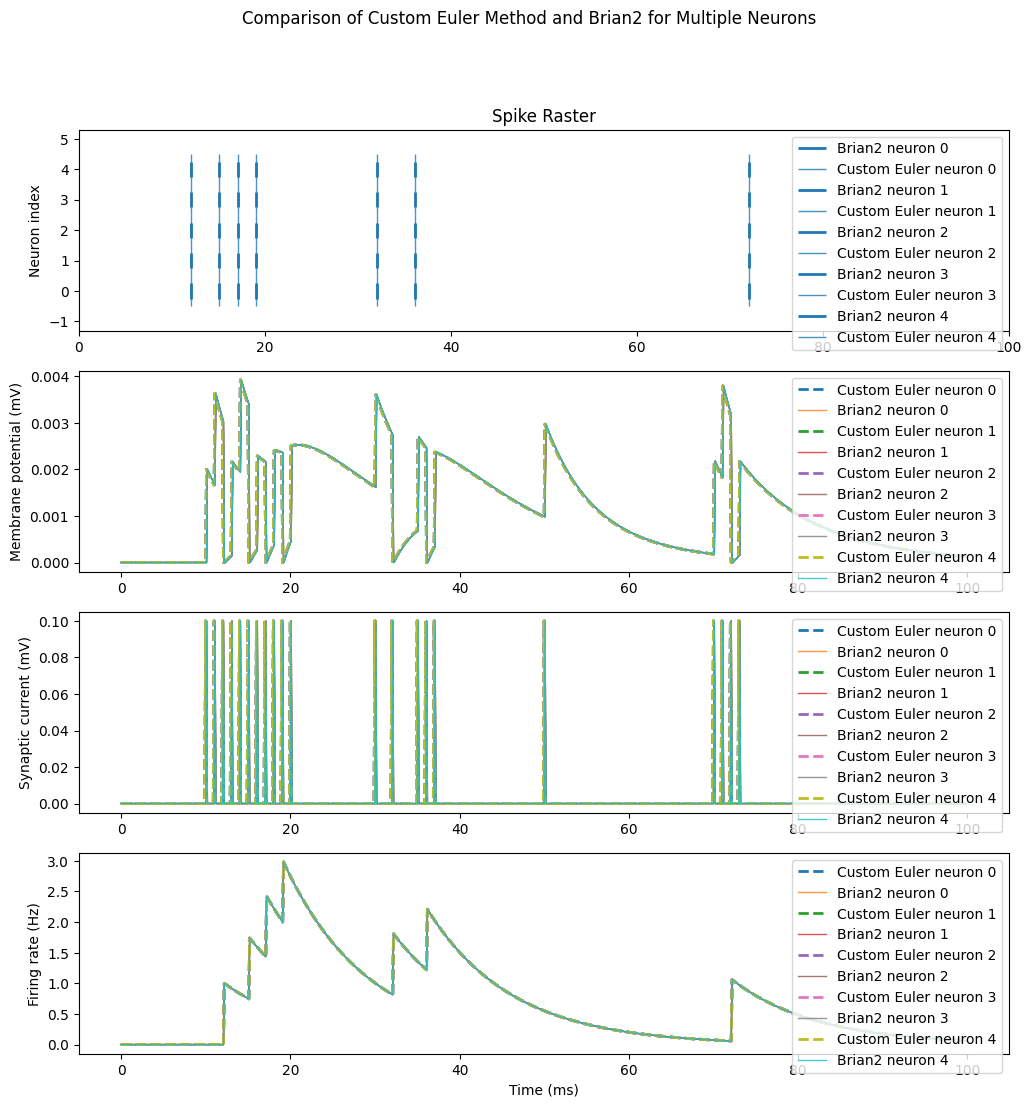

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Simulation parameters
num_neurons = 5   # Number of neurons
duration    = 100 * ms  # Total simulation time
dt          = 0.1 * ms        # Time step
tau         = 5 * ms         # Membrane time constant
tauf        = dt            # Synaptic current decay time constant
taus        = 10 * ms       # Slow synaptic current decay time constant
wslow       = 0.001 * mV
I0          = 10 * mV         # Synaptic input magnitude per spike
spike_times = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 32, 35, 36, 37, 50, 70, 71, 72, 73] * ms  # Presynaptic spike times
v_th        = 0.004 * mV
v_reset     = 0 * mV  # Reset voltage after spike

defaultclock.dt = dt  # Set simulation time step

# Start a clean simulation scope
start_scope()

# Neuron model equations
eqs = '''
dv/dt = (-v + I_f + I_s) / tau : volt
dI_f/dt = -I_f / tauf : volt
dI_s/dt = (-I_s + wslow * r) / tauf : volt
dr/dt = -r / taus  : 1
'''

# Create multiple postsynaptic neurons
G = NeuronGroup(num_neurons, eqs, threshold='v > v_th', reset='v = v_reset', method='euler')

# Presynaptic spike generator
spike_gen = SpikeGeneratorGroup(1, indices=[0] * len(spike_times), times=spike_times)

# Define synapse: inject current on presynaptic spikes
S = Synapses(spike_gen, G, on_pre=f'I_f += (I0/{tauf/ms})/1000')
S.connect()  

# Define slow synapse between neurons
S2 = Synapses(G, G, on_pre='r += 1')
S2.connect('i==j')  # Connect randomly

# Initialize variables
G.v = 0 * mV
G.I_f = 0 * mV
G.I_s = 0 * mV

# Monitor voltage, synaptic currents, and firing rate
mon = StateMonitor(G, ['v', 'I_f', 'r'], record=True)
spike_mon = SpikeMonitor(G)

# Run the Brian2 simulation
run(duration)

# Time vector for custom Euler method
time = np.arange(0, duration/ms, dt/ms)
num_steps = len(time)

# Vectorized custom Euler method simulation
v_euler = np.zeros((num_neurons, num_steps))  # Membrane potential
I_euler = np.zeros((num_neurons, num_steps))  # Synaptic current
r_euler = np.zeros((num_neurons, num_steps))  # Slow synaptic current
spike_euler = np.zeros((num_neurons, num_steps))  # Spike train
spiket_euler = [[] for _ in range(num_neurons)]  # Spike times for each neuron

# Create a binary spike mask
spike_mask = np.isin(time, spike_times/ms)

# Compute Euler method in a vectorized manner
for t_idx in range(num_steps - 1):
    # Apply synaptic input using the binary mask
    I_euler[:, t_idx] += (I0/dt * ms) * spike_mask[t_idx]
    
    # Euler update step for all neurons simultaneously
    dv_dt = (-v_euler[:, t_idx] + I_euler[:, t_idx] + (wslow/mV) * r_euler[:, t_idx]) / tau * dt
    dI_dt = -I_euler[:, t_idx] / tauf * dt
    dr_dt = -r_euler[:, t_idx] / taus * dt + spike_euler[:, t_idx] * dt/ms

    # Update variables
    v_euler[:, t_idx + 1] = v_euler[:, t_idx] + dv_dt
    I_euler[:, t_idx + 1] = I_euler[:, t_idx] + dI_dt
    r_euler[:, t_idx + 1] = r_euler[:, t_idx] + dr_dt

    # Apply threshold and reset
    spiking_neurons                         = v_euler[:, t_idx + 1] > v_th/mV
    v_euler[spiking_neurons, t_idx + 1]     = v_reset/mV  # Reset voltage
    spike_euler[spiking_neurons, t_idx + 1] = 1/dt*ms  # Mark spike event

    # Store spike times for raster plot
    for neuron in np.where(spiking_neurons)[0]:
        spiket_euler[neuron].append((time[t_idx] * ms) + dt)

# Plot comparison
plt.figure(figsize=(12, 12))

# Spike raster plot
plt.subplot(4, 1, 1)
for neuron in range(num_neurons):
    plt.eventplot(spike_mon.t[spike_mon.i == neuron] / ms, linelengths=0.5, lineoffsets=neuron, label=f"Brian2 neuron {neuron}", alpha=1, linewidth=2)
    plt.eventplot(np.array(spiket_euler[neuron]) / ms, lineoffsets=neuron, linelengths=1, label=f"Custom Euler neuron {neuron}", alpha=0.8, linewidth=1)
plt.ylabel("Neuron index")
plt.title("Spike Raster")
plt.xlim(0, duration/ms)
plt.legend()

# Compare membrane potentials
plt.subplot(4, 1, 2)
for neuron in range(num_neurons):
    plt.plot(time, v_euler[neuron], linestyle="dashed", alpha=1, linewidth=2, label=f"Custom Euler neuron {neuron}")
    plt.plot(mon.t/ms, mon.v[neuron]/mV, alpha=0.8, linewidth=1, label=f"Brian2 neuron {neuron}")
plt.ylabel("Membrane potential (mV)")
plt.legend()

# Compare synaptic currents
plt.subplot(4, 1, 3)
for neuron in range(num_neurons):
    plt.plot(time, I_euler[neuron], linestyle="dashed", alpha=1, linewidth=2, label=f"Custom Euler neuron {neuron}")
    plt.plot(mon.t/ms, mon.I_f[neuron]/mV, alpha=0.8, linewidth=1, label=f"Brian2 neuron {neuron}")
plt.ylabel("Synaptic current (mV)")
plt.legend()

# Compare firing rates
plt.subplot(4, 1, 4)
for neuron in range(num_neurons):
    plt.plot(time, r_euler[neuron], linestyle="dashed", alpha=1, linewidth=2, label=f"Custom Euler neuron {neuron}")
    plt.plot(mon.t/ms, mon.r[neuron], alpha=0.8, linewidth=1, label=f"Brian2 neuron {neuron}")
plt.xlabel("Time (ms)")
plt.ylabel("Firing rate (Hz)")
plt.legend()

plt.suptitle("Comparison of Custom Euler Method and Brian2 for Multiple Neurons")
plt.show()


## Expanding the Neuron Model: Recurrent Connections Between Neurons

In this step, we extend the neuron population model by introducing **recurrent connections** between neurons. Now, instead of each neuron's firing rate variable $r$ influencing only itself, it also affects **other neurons in the network** through synaptic connections.

**Mathematical Model**

Each neuron follows the same basic dynamics, but now incorporates recurrent interactions:

$$
\frac{dr_i}{dt} = \frac{-r_i}{\tau_r} + o_i(t)
$$

where:
- $r_i$ represents the neuron's internal firing rate,
- $\tau_r$ is the decay time constant for $r$,
- $o_i(t)$ is the spike train of neuron $i$ (binary: 0 or 1),
- The $r$ variable now contributes to other neurons' activity.

The slow synaptic current now includes input from all other neurons:

$$
\frac{dI_{s,i}}{dt} = \frac{-I_{s,i} + I_{\text{syn}, i}}{\tau_s}
$$

where $I_{\text{syn}, i}$ is the total recurrent synaptic input received by neuron $i$. This input is computed as:

$$
I_{\text{syn}, i} = \sum_j w_{ij} r_j
$$

where:
- $w_{ij}$ is the synaptic weight from neuron $j$ to neuron $i$,
- $r_j$ is the firing rate of neuron $j$.

Finally, the membrane potential evolves according to:

$$
\frac{dv_i}{dt} = \frac{-v_i + I_{f,i} + I_{s,i}}{\tau}
$$

where:
- $v_i$ is the membrane potential of the $i$-th neuron,
- $I_{f,i}$ is the fast synaptic input,
- $I_{s,i}$ is the slow synaptic input.

**Implementation in Brian2**

The **Brian2 framework** is used to simulate this recurrently connected network:
- **Neuron population**: A group of neurons, each with its own $r$ value.
- **Recurrent synapses**: Each neuron influences others via a weighted connection.
- **Synaptic weights**: Randomized values within a fixed range.
- **Spike-based updating**: When a neuron spikes, $r$ increases and influences connected neurons.

In this model:
- The synaptic weights $w_{ij}$ are initialized with small random values.
- Each neuron updates its slow synaptic input $I_{\text{syn}, i}$ based on all other neurons' $r$ values.
- The custom **Euler method** is used alongside Brian2 to validate the simulation.




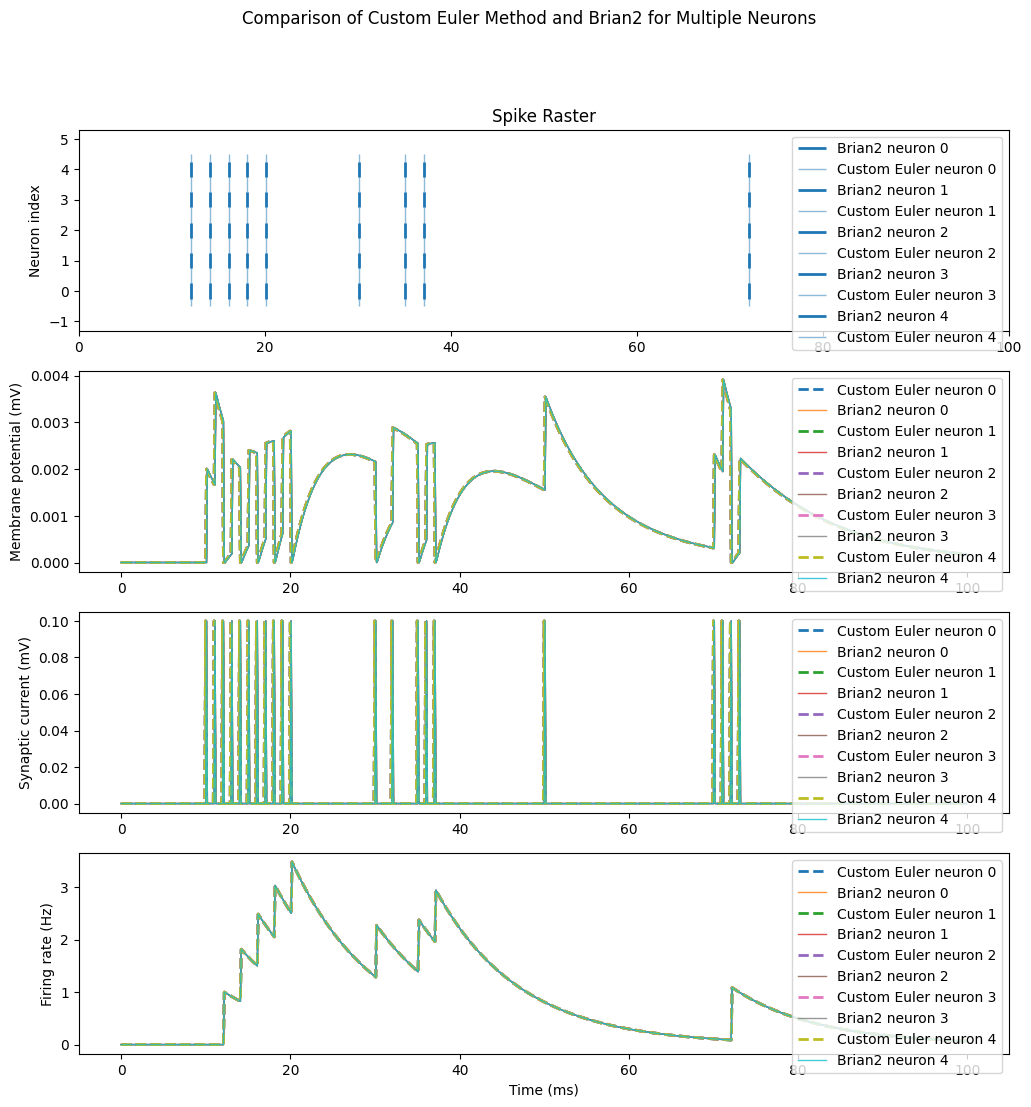

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Simulation parameters
num_neurons   = 5   # Number of neurons
duration      = 100 * ms  # Total simulation time
dt            = 0.1 * ms        # Time step
tau           = 5 * ms         # Membrane time constant
tauf          = dt            # Synaptic current decay time constant
taus          = 10 * ms       # Slow synaptic current decay time constant
base_wslow    = np.random.uniform(0.0001, 0.0005, num_neurons) * mV
wslow         = np.tile(base_wslow, (num_neurons, 1))
I0            = 10 * mV         # Synaptic input magnitude per spike
spike_times   = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 32, 35, 36, 37, 50, 70, 71, 72, 73] * ms  # Presynaptic spike times
v_th          = 0.004 * mV
v_reset       = 0 * mV  # Reset voltage after spike

defaultclock.dt = dt  # Set simulation time step

# Start a clean simulation scope
start_scope()

# Neuron model equations
eqs = '''
dv/dt = (-v + I_f + I_s) / tau : volt
dI_f/dt = -I_f / tauf : volt
dI_s/dt = (-I_s + I_syn) / tauf : volt
dr/dt = -r / taus  : 1
I_syn : volt
'''

# Create multiple postsynaptic neurons
G = NeuronGroup(num_neurons, eqs, threshold='v > v_th', reset='v = v_reset', method='euler')

# Presynaptic spike generator
spike_gen = SpikeGeneratorGroup(1, indices=[0] * len(spike_times), times=spike_times)

# Define synapse: inject current on presynaptic spikes
S = Synapses(spike_gen, G, on_pre=f'I_f += (I0/{tauf/ms})/1000')
S.connect()  

# Define slow synapse between neurons
S2 = Synapses(G, G, on_pre='r += 1')
S2.connect('i==j') 

# Define synapse with weight variable and synaptic effect
S3 = Synapses(G, G, model='''w: volt
               I_syn_post = w * r_pre : volt (summed)''')
S3.connect()  
S3.w = wslow[S3.j, S3.i] 

# Initialize variables
G.v = 0 * mV
G.I_f = 0 * mV
G.I_s = 0 * mV

# Monitor voltage, synaptic currents, and firing rate
mon = StateMonitor(G, ['v', 'I_f', 'r'], record=True)
spike_mon = SpikeMonitor(G)

# Run the Brian2 simulation
run(duration)

# Time vector for custom Euler method
time = np.arange(0, duration/ms, dt/ms)
num_steps = len(time)

# Vectorized custom Euler method simulation
v_euler = np.zeros((num_neurons, num_steps))  # Membrane potential
I_euler = np.zeros((num_neurons, num_steps))  # Synaptic current
r_euler = np.zeros((num_neurons, num_steps))  # Slow synaptic current
spike_euler = np.zeros((num_neurons, num_steps))  # Spike train
spiket_euler = [[] for _ in range(num_neurons)]  # Spike times for each neuron

# Create a binary spike mask
spike_mask = np.isin(time, spike_times/ms)

# Compute Euler method in a vectorized manner
for t_idx in range(num_steps - 1):
    # Apply synaptic input using the binary mask
    I_euler[:, t_idx] += (I0/dt * ms) * spike_mask[t_idx]
    
    # Euler update step for all neurons simultaneously
    dv_dt = (-v_euler[:, t_idx] + I_euler[:, t_idx] + (wslow/mV) @ r_euler[:, t_idx]) / tau * dt
    dI_dt = -I_euler[:, t_idx] / tauf * dt
    dr_dt = -r_euler[:, t_idx] / taus * dt + spike_euler[:, t_idx] * dt/ms

    # Update variables
    v_euler[:, t_idx + 1] = v_euler[:, t_idx] + dv_dt
    I_euler[:, t_idx + 1] = I_euler[:, t_idx] + dI_dt
    r_euler[:, t_idx + 1] = r_euler[:, t_idx] + dr_dt

    # Apply threshold and reset
    spiking_neurons                          = v_euler[:, t_idx + 1] > v_th/mV
    v_euler[spiking_neurons, t_idx + 1]      = v_reset/mV  # Reset voltage
    spike_euler[spiking_neurons, t_idx + 1]  = 1/dt*ms  # Mark spike event

    # Store spike times for raster plot
    for neuron in np.where(spiking_neurons)[0]:
        spiket_euler[neuron].append((time[t_idx] * ms) + dt)

# Plot comparison
plt.figure(figsize=(12, 12))

# Spike raster plot
plt.subplot(4, 1, 1)
for neuron in range(num_neurons):
    plt.eventplot(spike_mon.t[spike_mon.i == neuron] / ms, lineoffsets=neuron, label=f"Brian2 neuron {neuron}", linelengths=0.5, alpha=1, linewidth=2)
    plt.eventplot(np.array(spiket_euler[neuron]) / ms, lineoffsets=neuron, label=f"Custom Euler neuron {neuron}", linelengths=1, alpha=0.5, linewidth=1)
plt.ylabel("Neuron index")
plt.title("Spike Raster")
plt.xlim(0, duration/ms)
plt.legend()

# Compare membrane potentials
plt.subplot(4, 1, 2)
for neuron in range(num_neurons):
    plt.plot(time, v_euler[neuron], linestyle="dashed", alpha=1, linewidth=2, label=f"Custom Euler neuron {neuron}")
    plt.plot(mon.t/ms, mon.v[neuron]/mV, alpha=0.8, linewidth=1, label=f"Brian2 neuron {neuron}")
plt.ylabel("Membrane potential (mV)")
plt.legend()

# Compare synaptic currents
plt.subplot(4, 1, 3)
for neuron in range(num_neurons):
    plt.plot(time, I_euler[neuron], linestyle="dashed", alpha=1, linewidth=2, label=f"Custom Euler neuron {neuron}")
    plt.plot(mon.t/ms, mon.I_f[neuron]/mV, alpha=0.8, linewidth=1, label=f"Brian2 neuron {neuron}")
plt.ylabel("Synaptic current (mV)")
plt.legend()

# Compare firing rates
plt.subplot(4, 1, 4)
for neuron in range(num_neurons):
    plt.plot(time, r_euler[neuron], linestyle="dashed", alpha=1, linewidth=2, label=f"Custom Euler neuron {neuron}")
    plt.plot(mon.t/ms, mon.r[neuron], alpha=0.8, linewidth=1, label=f"Brian2 neuron {neuron}")
plt.xlabel("Time (ms)")
plt.ylabel("Firing rate (Hz)")
plt.legend()

plt.suptitle("Comparison of Custom Euler Method and Brian2 for Multiple Neurons")
plt.show()
